<a href="https://colab.research.google.com/github/garretbassett/DS-Unit-1-Sprint-1-Dealing-With-Data/blob/master/module1-afirstlookatdata/LS_DS_111_A_First_Look_at_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lambda School Data Science - A First Look at Data



## Lecture - let's explore Python DS libraries and examples!

The Python Data Science ecosystem is huge. You've seen some of the big pieces - pandas, scikit-learn, matplotlib. What parts do you want to see more of?

In [0]:
# TODO - we'll be doing this live, taking requests
# and reproducing what it is to look up and learn things

###QUESTIONS

1. What did Bruno say about always using two sets of brackets in dataframes?
2. Could I use `replace()` instead of `at`?
3. `.iloc` vs. `.loc` vs. `.at`?

In [110]:
import pandas as pd
drinks_list = pd.read_csv('https://raw.githubusercontent.com/fivethirtyeight/data/master/alcohol-consumption/drinks.csv')
drinks_list.head()

,country,beer_servings,spirit_servings,wine_servings,total_litres_of_pure_alcohol
0,Afghanistan,0,0,0,0.0
1,Albania,89,132,54,4.9
2,Algeria,25,0,14,0.7
3,Andorra,245,138,312,12.4
4,Angola,217,57,45,5.9


In [111]:
import numpy as np
drinks_list['drinks_alcohol'] = np.where(drinks_list['total_litres_of_pure_alcohol'] > 9, 'High',
np.where(drinks_list['total_litres_of_pure_alcohol'] >= 6, 'Medium',
np.where(drinks_list['total_litres_of_pure_alcohol'] == 0, 'None', 'Low')))
drinks_list.head()

,country,beer_servings,spirit_servings,wine_servings,total_litres_of_pure_alcohol,drinks_alcohol
0,Afghanistan,0,0,0,0.0,None
1,Albania,89,132,54,4.9,Low
2,Algeria,25,0,14,0.7,Low
3,Andorra,245,138,312,12.4,High
4,Angola,217,57,45,5.9,Low


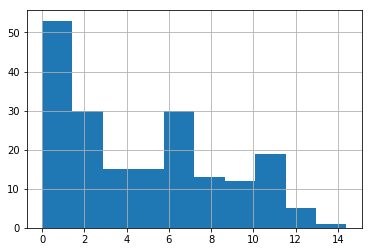

In [112]:
import matplotlib.pyplot as plt
%matplotlib inline

drinks_list.total_litres_of_pure_alcohol.hist()
plt.show()

In [113]:
countries = pd.read_csv('https://raw.githubusercontent.com/lukes/ISO-3166-Countries-with-Regional-Codes/master/all/all.csv')
print(countries.shape)
countries.head()

(249, 11)


,name,alpha-2,alpha-3,country-code,iso_3166-2,region,sub-region,intermediate-region,region-code,sub-region-code,intermediate-region-code
0,Afghanistan,AF,AFG,4,ISO 3166-2:AF,Asia,Southern Asia,NaN,142.0,34.0,NaN
1,Åland Islands,AX,ALA,248,ISO 3166-2:AX,Europe,Northern Europe,NaN,150.0,154.0,NaN
2,Albania,AL,ALB,8,ISO 3166-2:AL,Europe,Southern Europe,NaN,150.0,39.0,NaN
3,Algeria,DZ,DZA,12,ISO 3166-2:DZ,Africa,Northern Africa,NaN,2.0,15.0,NaN
4,American Samoa,AS,ASM,16,ISO 3166-2:AS,Oceania,Polynesia,NaN,9.0,61.0,NaN


In [114]:
# WHAT WAS BRUNO SAYING ABOUT USING TWO SETS OF BRACKETS WITH A DATAFRAME?

drinks_list.at[184, 'country'] = 'United States of America'

# df = drinks_list.join(countries[['name', 'region', 'sub-region']], how='left', lsuffix = 'country', rsuffix = 'name')
df = drinks_list.merge(countries[['name', 'region', 'sub-region']], how='left', left_on = 'country', right_on = 'name')
df.head(20)
# df.info()

,country,beer_servings,spirit_servings,wine_servings,total_litres_of_pure_alcohol,drinks_alcohol,name,region,sub-region
0,Afghanistan,0,0,0,0.0,None,Afghanistan,Asia,Southern Asia
1,Albania,89,132,54,4.9,Low,Albania,Europe,Southern Europe
2,Algeria,25,0,14,0.7,Low,Algeria,Africa,Northern Africa
3,Andorra,245,138,312,12.4,High,Andorra,Europe,Southern Europe
4,Angola,217,57,45,5.9,Low,Angola,Africa,Sub-Saharan Africa
5,Antigua & Barbuda,102,128,45,4.9,Low,NaN,NaN,NaN
6,Argentina,193,25,221,8.3,Medium,Argentina,Americas,Latin America and the Caribbean
7,Armenia,21,179,11,3.8,Low,Armenia,Asia,Western Asia
8,Australia,261,72,212,10.4,High,Australia,Oceania,Australia and New Zealand
9,Austria,279,75,191,9.7,High,Austria,Europe,Western Europe


In [115]:
df[df.region.isna()]



,country,beer_servings,spirit_servings,wine_servings,total_litres_of_pure_alcohol,drinks_alcohol,name,region,sub-region
5,Antigua & Barbuda,102,128,45,4.9,Low,NaN,NaN,NaN
20,Bolivia,167,41,8,3.8,Low,NaN,NaN,NaN
21,Bosnia-Herzegovina,76,173,8,4.6,Low,NaN,NaN,NaN
24,Brunei,31,2,1,0.6,Low,NaN,NaN,NaN
28,Cote d'Ivoire,37,1,7,4.0,Low,NaN,NaN,NaN
45,Czech Republic,361,170,134,11.8,High,NaN,NaN,NaN
46,North Korea,0,0,0,0.0,None,NaN,NaN,NaN
47,DR Congo,32,3,1,2.3,Low,NaN,NaN,NaN
79,Iran,0,0,0,0.0,None,NaN,NaN,NaN
92,Laos,62,0,123,6.2,Medium,NaN,NaN,NaN


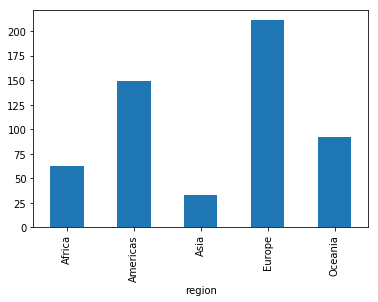

In [116]:
df['sub-region'].value_counts()
df.groupby('region')['beer_servings'].mean().plot(kind='bar', sort_columns=True)
plt.show()

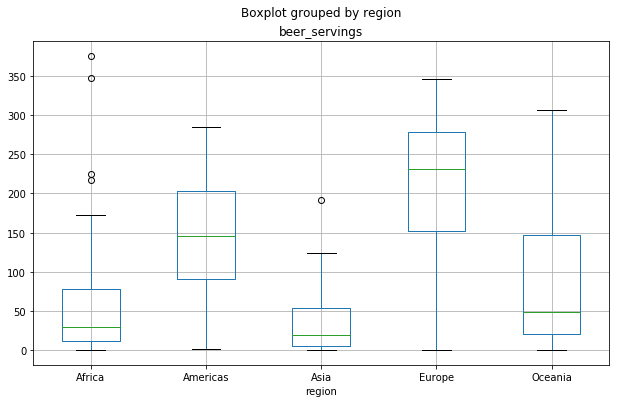

In [117]:
df.boxplot(column='beer_servings', by='region', figsize=(10,6))
plt.show()

In [118]:
df = df.dropna(subset=['region'])
df.shape

(168, 9)

In [119]:
from bokeh.io import output_file, show, output_notebook
from bokeh.models import ColumnDataSource, HoverTool, CategoricalColorMapper
from bokeh.palettes import d3
from bokeh.plotting import figure
from bokeh.transform import transform
output_notebook()
x = df.beer_servings.values
y = df.wine_servings.values
country = df.country
region = df.region
source = ColumnDataSource(data=dict(x=x, y=y, country=country, region=region))
hover = HoverTool(tooltips=[
    ("index", "$index"),
    ("(x,y)", "(@x, @y)"),
    ('country', '@country'),
])
palette = d3['Category10'][len(df['region'].unique())]
mapper = CategoricalColorMapper(factors = df['region'].unique(), palette = palette)
# create figure and plot
p = figure(plot_width=600, plot_height=600, 
           tools=[hover, "wheel_zoom", "box_zoom", "reset"], 
           title="Beer and Wine Servings per Year by Country")
# create plot
p.scatter(x='x', y='y', size=10, alpha=0.8,
          color={'field': 'region', 'transform': mapper},
          legend='region', 
          source=source)
# add axis labels
p.xaxis.axis_label = "Beer Servings"
p.yaxis.axis_label = "Wine Servings"
output_file('interactive_bokeh_plot.html')
show(p)

Loading BokehJS ...

## Assignment - now it's your turn

Pick at least one Python DS library, and using documentation/examples reproduce in this notebook something cool. It's OK if you don't fully understand it or get it 100% working, but do put in effort and look things up.

### Assignment questions

After you've worked on some code, answer the following questions in this text block:

1.  Describe in a paragraph of text what you did and why, as if you were writing an email to somebody interested but nontechnical.

**I am still in the process of finishing, but my objective is to analyze the lyrics from songs that made the yearly Billboard Hot 100 from 1964 to 2015. For now, the furthest I've gotten is analyzing average length of the longest word by year. Here's how I got there:

- **Read in a raw file; eliminated all rows with null or blank values**
- **Define a function which identifies the longest word in each song, as contained in the `Lyrics` column**
- **Create new columns containing the longest word and its length in integers**
- **Plot average word length by year**

2.  What was the most challenging part of what you did?

**For now, the biggest challenge is finding the right balance between truly understanding what is going on "underneath the hood", and being pragmatic and finishing the project in the short time I have.**

3.  What was the most interesting thing you learned?

**`df.tail(X)` produces the last X rows of the dataframe. Also, word length seems to trend up slightly over time.**

4.  What area would you like to explore with more time?

**I would like to analyze word frequency and variety over time and see how it compares to word length. It would also be interesting to join this table with a table containing the genres for each artist and then segment the same analyses by genre.**

**I also need to do a good deal more cleaning on the `Lyrics` field. For example, spaces seem to have been omitted rather frequently, artificially inflating word length. Also, the artist and song name are contained in the lyrics.**

###Billboard Hot 100 Text Analysis

What I want to do is analyze the lyrics of the Billboard Top 100 songs from 1964 - 2015. Potential analyses:

- What are the most common words (above a certain length threshold)
- How does mean word length trend over time?
- How does mean word variety trend over time?

In [244]:
music = pd.read_csv('https://raw.githubusercontent.com/walkerkq/musiclyrics/master/billboard_lyrics_1964-2015.csv', encoding='latin-1')
  
music.head(20)

,Rank,Song,Artist,Year,Lyrics,Source
0,1,wooly bully,sam the sham and the pharaohs,1965,sam the sham miscellaneous wooly bully wooly b...,3.0
1,2,i cant help myself sugar pie honey bunch,four tops,1965,sugar pie honey bunch you know that i love yo...,1.0
2,3,i cant get no satisfaction,the rolling stones,1965,,1.0
3,4,you were on my mind,we five,1965,when i woke up this morning you were on my mi...,1.0
4,5,youve lost that lovin feelin,the righteous brothers,1965,you never close your eyes anymore when i kiss...,1.0
5,6,downtown,petula clark,1965,when youre alone and life is making you lonel...,1.0
6,7,help,the beatles,1965,help i need somebody help not just anybody hel...,3.0
7,8,cant you hear my heart beat,hermans hermits,1965,carterlewis every time i see you lookin my way...,5.0
8,9,crying in the chapel,elvis presley,1965,you saw me crying in the chapel the tears i s...,1.0
9,10,my girl,the temptations,1965,ive got sunshine on a cloudy day when its cold...,3.0


In [256]:
music.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4851 entries, 0 to 4850
Data columns (total 9 columns):
index          4851 non-null int64
Rank           4851 non-null int64
Song           4851 non-null object
Artist         4851 non-null object
Year           4851 non-null int64
Lyrics         4851 non-null object
Source         4851 non-null float64
longest        4851 non-null object
longest_int    4851 non-null float64
dtypes: float64(2), int64(3), object(4)
memory usage: 341.2+ KB


In [257]:
# Some blanks had one space vs. multiple spaces. I need to find a more elegant way to fix this.
music['Lyrics'].replace('instrumental', np.nan, inplace=True)
music['Lyrics'].replace(' ', np.nan, inplace=True)
music['Lyrics'].replace('  ', np.nan, inplace=True)
music['Lyrics'].replace('   ', np.nan, inplace=True)
music['Lyrics'].replace('    ', np.nan, inplace=True)
music = music.dropna(subset=['Lyrics']).reset_index()
music.head()
# print('A',music['Lyrics'][2],'A')

,level_0,index,Rank,Song,Artist,Year,Lyrics,Source,longest,longest_int
0,0,0,1,wooly bully,sam the sham and the pharaohs,1965,sam the sham miscellaneous wooly bully wooly b...,3.0,miscellaneous,13.0
1,1,1,2,i cant help myself sugar pie honey bunch,four tops,1965,sugar pie honey bunch you know that i love yo...,1.0,myselfsugar,11.0
2,2,3,4,you were on my mind,we five,1965,when i woke up this morning you were on my mi...,1.0,shooooooes,10.0
3,3,4,5,youve lost that lovin feelin,the righteous brothers,1965,you never close your eyes anymore when i kiss...,1.0,tenderness,10.0
4,4,5,6,downtown,petula clark,1965,when youre alone and life is making you lonel...,1.0,nowdowntownand,14.0


In [258]:
def find_longest(text):
  text = text.split()
  # print(text)
  longest = text[0]
  # print(longest)
  for index in range(0, len(text)-1):
    # print(text[index+1], len(text[index+1]))
    if len(text[index]) > len(longest):
      longest = text[index]
  return(longest)

test1 = find_longest(music['Lyrics'][0])
print(test1)

miscellaneous


In [259]:
for index in range(0, len(music['Lyrics'])):
  music.loc[index, 'longest'] = find_longest(music['Lyrics'][index])
  # print(index, music['Artist'][index], music['longest'][index])
for index in range(0, len(music['Lyrics'])):
  music.loc[index, 'longest_int'] = len(music['longest'][index])
music.tail()

,level_0,index,Rank,Song,Artist,Year,Lyrics,Source,longest,longest_int
4846,4846,5094,95,waves,mr probz,2015,my face above the water my feet cant touch th...,1.0,everytime,9.0
4847,4847,5095,96,el perdon,nicky jam and enrique iglesias,2015,enrique iglesias dime si es verdad me dijeron ...,3.0,insistiendo,11.0
4848,4848,5097,98,night changes,one direction,2015,going out tonight changes into something red ...,1.0,disappearing,12.0
4849,4849,5098,99,back to back,drake,2015,oh man oh man oh man not againyeah i learned ...,1.0,pretentious,11.0
4850,4850,5099,100,how deep is your love,calvin harris and disciples,2015,i want you to breathe me in let me be your ai...,1.0,inhibition,10.0


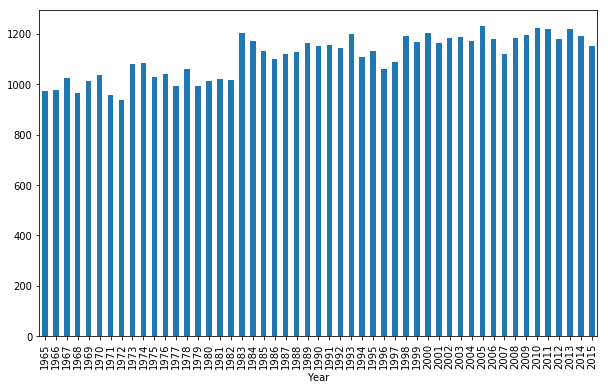

In [269]:
# mean_long = np.mean(music['longest_int'])
# plt.hist(mean_long, bins=100)
# plt.show()

# df.groupby('region')['beer_servings'].mean().plot(kind='bar', sort_columns=True)
mean_test = music.groupby('Year')['longest_int'].sum()
mean_test.plot(kind='bar', figsize=(10,6))
plt.show()

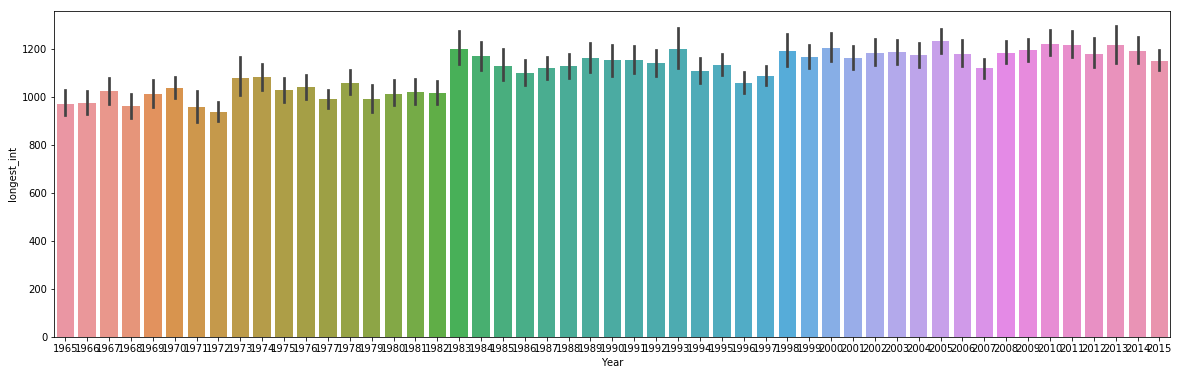

In [273]:
import seaborn as sns
# a = sns.barplot(data=mean_test)
plt.figure(figsize=(20,6))
a = sns.barplot(x=music['Year'], y=music['longest_int'], estimator=sum)

## Stretch goals and resources

Following are *optional* things for you to take a look at. Focus on the above assignment first, and make sure to commit and push your changes to GitHub (and since this is the first assignment of the sprint, open a PR as well).

- [pandas documentation](https://pandas.pydata.org/pandas-docs/stable/)
- [scikit-learn documentation](http://scikit-learn.org/stable/documentation.html)
- [matplotlib documentation](https://matplotlib.org/contents.html)
- [Awesome Data Science](https://github.com/bulutyazilim/awesome-datascience) - a list of many types of DS resources

Stretch goals:

- Find and read blogs, walkthroughs, and other examples of people working through cool things with data science - and share with your classmates!
- Write a blog post (Medium is a popular place to publish) introducing yourself as somebody learning data science, and talking about what you've learned already and what you're excited to learn more about.